<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import warnings
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

import lightgbm as lgbm
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_validate
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

warnings.filterwarnings('ignore')


Посмотрим данные

In [2]:
try:
    data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])  
except:
    data = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])

data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные есть с 1 марта 2018 года по 31 августа 2018 года, предоставляются каждые 10 минут. Сделаем ресемплирование по одному часу

In [4]:
data = data.resample("1H").sum()

## Анализ

<AxesSubplot: xlabel='datetime'>

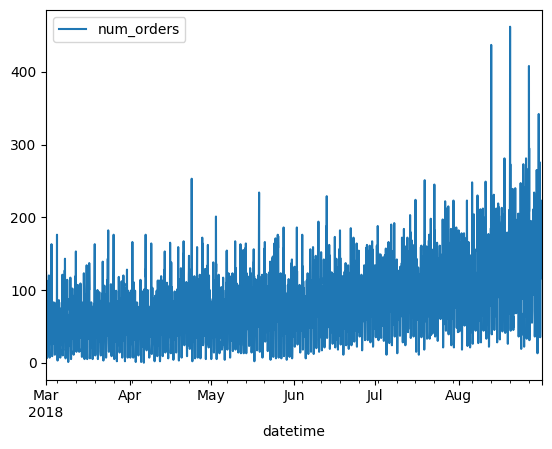

In [5]:
data.plot()

Возьмем меньший период, чтобы было видно закономерности

<AxesSubplot: xlabel='datetime'>

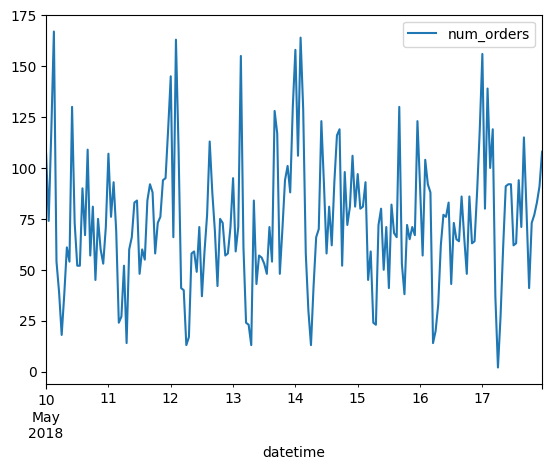

In [6]:
data['2018-05-10':'2018-05-17'].plot()

Заметим, что к вечеру заказов становится явно больше по сравнению с утром.  
Разобьем временной ряд на тренд, сезонность и остаток

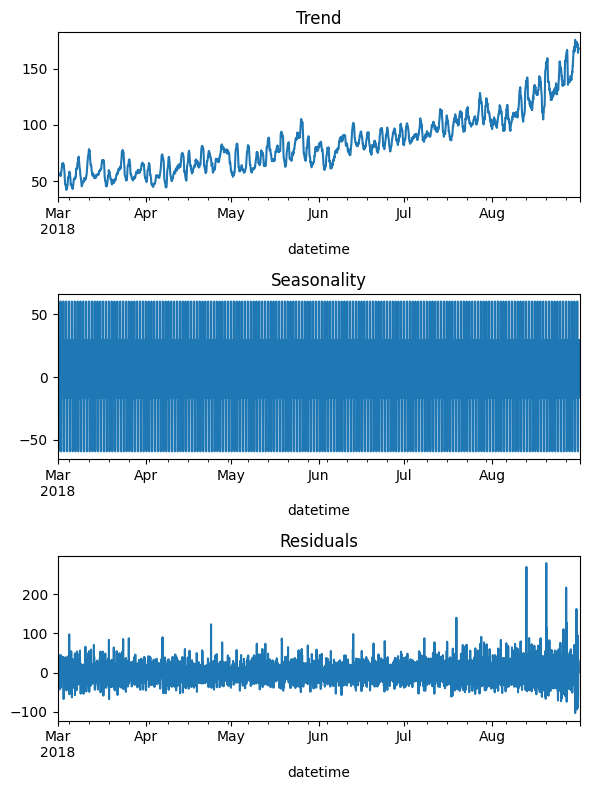

In [7]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд растет к концу лета. Сезонность с периодом меньше месяца - исследуем ее дальше.

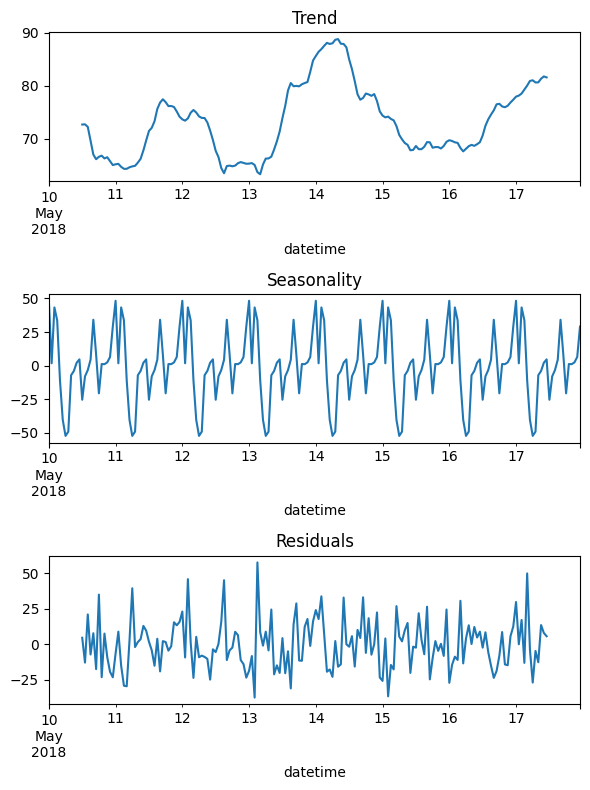

In [8]:
decomposed = seasonal_decompose(data['2018-05-10':'2018-05-17']) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод**
* Дисперсия увеличичвается
* Тренд в общем растет, то есть кол-во заказов и пользователей растет
* Видно что в раннее утро кол-во заказов резко падает
* Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.

Прогнозировать данные помогают стационарные ряды. Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Посмотрим на разности нашего ряда

<AxesSubplot: xlabel='datetime'>

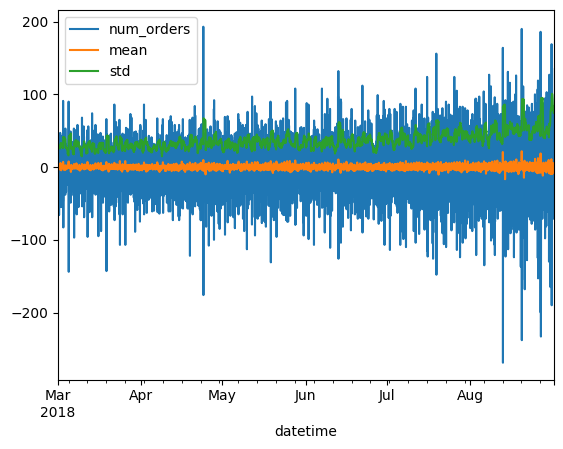

In [9]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(20).mean()
data_shift['std'] = data_shift['num_orders'].rolling(20).std()
data_shift.plot()

Ряд стационарен  
Теперь создадим признаки для прогноза

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
max_lag = 24
rolling_mean_size = 48
data_features = data.copy()
make_features(data_features, max_lag, rolling_mean_size)

Вопрос: как правильно выбирать max_lag и rolling_mean_size?

In [12]:
# Поделим нашу выборку
train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state=42)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

**Вывод**
* Данные проанализированы
* Признаки созданы
* Подготовка к обучению завершена

## Обучение

In [14]:
# TimeeriesSplit
splits = TimeSeriesSplit(n_splits=4)

* Liner Regression

In [14]:
%%time
lr_results = cross_validate(LinearRegression(), X_train, y_train, scoring='neg_root_mean_squared_error', cv=splits)
fit_time_lr = lr_results['fit_time'].mean()
score_time_lr = lr_results['score_time'].mean()
test_score_lr = lr_results['test_score'].mean() * (-1)
print('Время обучения: {},  время предсказания: {} и качество модели: {}'.format(fit_time_lr, score_time_lr, test_score_lr)) 

Время обучения: 0.005470216274261475,  время предсказания: 0.003825366497039795 и качество модели: 27.46189826344932
CPU times: total: 46.9 ms
Wall time: 40.2 ms


* Random Forest

In [15]:
%%time
RF = RandomForestRegressor(random_state=42,n_jobs=-1)
parameters = {'n_estimators': [100, 300,100], 'max_depth' : [1,10,2]}

search_rf = GridSearchCV(RF, parameters, cv=splits, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_rf.fit(X_train, y_train);    
        
results = search_rf.cv_results_
best_index = search_rf.best_index_

CPU times: total: 20.2 s
Wall time: 20.6 s


In [16]:
search_rf.best_params_

{'max_depth': 10, 'n_estimators': 300}

In [17]:
fit_time_rf = results['mean_fit_time'][best_index]
score_time_rf = results['mean_score_time'][best_index]
test_score_rf = results['mean_test_score'][best_index] * (-1)

print(f"Fit time: {fit_time_rf}, Predict time: {score_time_rf}, Best RMSE: {test_score_rf}")  

Fit time: 6.2856146693229675, Predict time: 1.6081626415252686, Best RMSE: 26.595937146988543


* CatBoostRegressor

In [15]:
%%time
catboost = CatBoostRegressor(loss_function="RMSE", random_state=42, verbose=False)
parameters = {'depth':[5,10], 'learning_rate':np.arange(0.1,0.5,0.2)}

search_catboost = GridSearchCV(catboost, parameters, cv=splits, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_catboost.fit(X_train, y_train);    
        
results = search_catboost.cv_results_
best_index = search_catboost.best_index_

CPU times: total: 21.6 s
Wall time: 5min 19s


In [16]:
search_catboost.best_params_

{'depth': 5, 'learning_rate': 0.1}

In [17]:
fit_time_cat = results['mean_fit_time'][best_index]
score_time_cat = results['mean_score_time'][best_index]
test_score_cat = results['mean_test_score'][best_index] * (-1)

print(f"Fit time: {fit_time_cat}, Predict time: {score_time_cat}, Best RMSE: {test_score_cat}")  

Fit time: 13.882468938827515, Predict time: 0.05479025840759277, Best RMSE: 26.214059896831667


* LightGBM

In [20]:
%%time
lgb = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=42, objective='rmse')

parameters = {'max_depth':[5,10], 'learning_rate':np.arange(0.1,0.5,0.2)}

search_lgb = GridSearchCV(lgb, parameters, cv=splits, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_lgb.fit(X_train, y_train);    
        
results = search_lgb.cv_results_
best_index = search_lgb.best_index_

CPU times: total: 7.77 s
Wall time: 11 s


In [21]:
search_lgb.best_params_

{'learning_rate': 0.1, 'max_depth': 10}

In [22]:
fit_time_lgb = results['mean_fit_time'][best_index]
score_time_lgb = results['mean_score_time'][best_index]
test_score_lgb = results['mean_test_score'][best_index] * (-1)

print(f"Fit time: {fit_time_lgb}, Predict time: {score_time_lgb}, Best RMSE: {test_score_lgb}")    

Fit time: 2.4022539854049683, Predict time: 0.17474156618118286, Best RMSE: 27.395541852212965


* Анализ моделей

In [31]:
column=['RMSE модели на CV','RMSE test','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=column, columns=['LineralRegressor','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LineralRegressor'] = test_score_lr, rmse_lr, fit_time_lr, score_time_lr
comparison_tabl['RandomForestRegressor'] = test_score_rf, rmse_rf, fit_time_rf, score_time_rf
comparison_tabl['CatBoostRegressor'] = test_score_cat, rmse_cat, fit_time_cat, score_time_cat
comparison_tabl['LightGBM'] = test_score_lgb, rmse_lgb, fit_time_lgb, score_time_lgb

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели на CV,RMSE test,"Скорость обучения, s","Скорость предсказания, s"
LineralRegressor,27.461898,47.222895,0.005470,0.003825
RandomForestRegressor,26.553630,43.726440,0.771003,0.034710
CatBoostRegressor,26.214060,41.998945,13.533369,0.066038
LightGBM,27.395542,42.157188,4.515123,0.246299


## Тестирование

In [25]:
pred_cat = search_catboost.predict(X_test)
rmse_cat = sqrt(mean_squared_error(y_test, pred_cat))
print("Catboost RMSE:", rmse_cat)

Catboost RMSE: 41.99894510816657


 Графики исходного и предсказанных рядов.

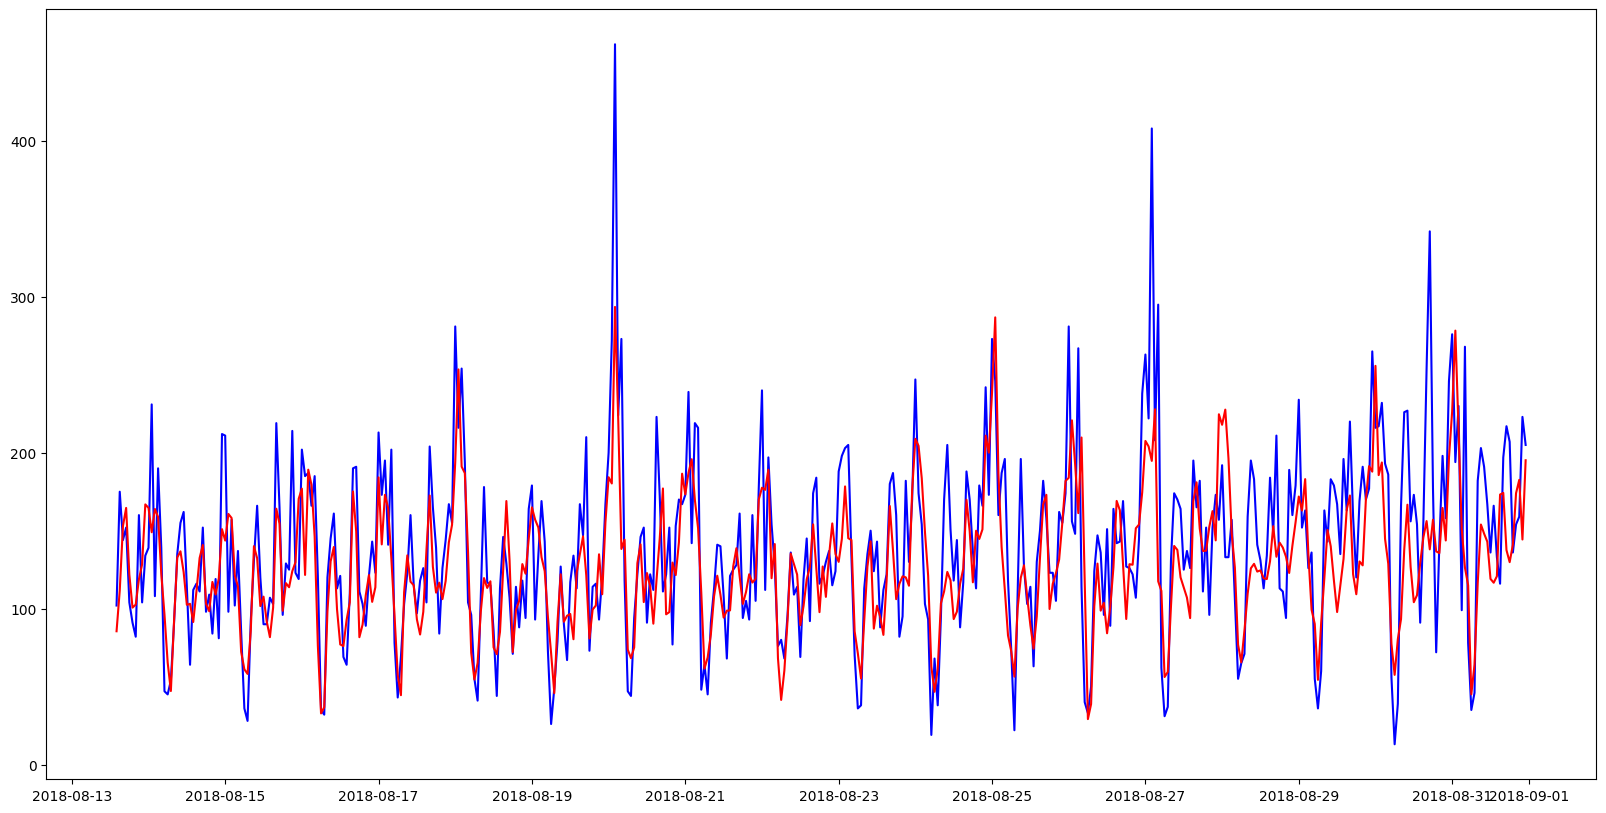

In [33]:
plt.figure(figsize=(20,10))
plt.plot(y_test.index, 
         y_test, 
         'b-', 
         y_test.index, 
         pred_cat,
         'r-')

## Вывод

Задача: построить модель для прогнозирования количества заказов такси на следующий час с RMSE меньше 48

* Мы ресемплировали ихсодные данные по одному часу и рассмотрели тренд, сезонность и остатки: в общем тренд растет, также количество заказов значительно больше в вечернее время
* Перешли к разностям нашего ряд - такой ряд является стационарным, что подходит для прогнозирования 
* Создали признаки для прогноза: max_lag = 24 и rolling_mean_size = 48
* Разделили выборку в соотношении 9:1
* Даллее рассмотрели модели LineralRegressor,RandomForestRegressor, CatBoostRegressor и LightGBM   



Все модели удовлетворяют требованию задания RMSE < 48, но по итогам качества и скорости обучения лучшей я считаю модель СatBoostRegressor. RMSE на тестовых данных = 42, скорость обучения = 13.5s, скорость предсказания = 0.06s

In [29]:
%%time
RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 100,n_jobs=-1)
RF_results = cross_validate(RF, X_train, y_train, scoring='neg_root_mean_squared_error', cv=splits)
fit_time_rf = RF_results['fit_time'].mean()
score_time_rf = RF_results['score_time'].mean()
test_score_rf = RF_results['test_score'].mean() * (-1)
print('Время обучения: {},  время предсказания: {} и качество модели: {}'.format(fit_time_rf, score_time_rf, test_score_rf)) 

Время обучения: 0.7710025906562805,  время предсказания: 0.0347098708152771 и качество модели: 26.553630062757932
CPU times: total: 1.17 s
Wall time: 3.22 s


## Чек-лист проверки